# AG New 데이터셋을 이용하여 뉴스 기사를 만드는 GPT 모델 구현하기

In [1]:
import time

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from transformers import OpenAIGPTTokenizer, OpenAIGPTModel
from datasets import load_dataset

In [2]:
ds = load_dataset("fancyzhx/ag_news")

In [3]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

OpenAI GPT Tokenizer 는 padding token 을 지원하지 않기 때문에 unk_token 을 pad_token 으로 설정해줍니다.

In [4]:
tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")
tokenizer.pad_token = tokenizer.unk_token
tokenizer

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


OpenAIGPTTokenizer(name_or_path='openai-gpt', vocab_size=40478, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

## AG News 데이터셋으로 DataLoader 생성

In [5]:
def collate_ag_news(batch):
    """
    AG News 데이터셋을 위한 collate 함수
    OpenAIGPTTokenizer 를 이용하여, input_ids, attention_mask, labels 를 반환
    """
    texts, labels = [], []

    for row in batch:
        texts.append(row["text"])
        labels.append(row["label"])

    tokenized = tokenizer(texts, padding=True, return_tensors="pt")

    return tokenized.input_ids, tokenized.attention_mask, torch.LongTensor(labels)


train_data_loader = DataLoader(
    ds["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_ag_news
)
test_data_loader = DataLoader(
    ds["test"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_ag_news
)

## OpenAI GPT 의 Pretrained Model 로드

In [6]:
openai_gpt = OpenAIGPTModel.from_pretrained("openai-gpt")
openai_gpt

OpenAIGPTModel(
  (tokens_embed): Embedding(40478, 768)
  (positions_embed): Embedding(512, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x Block(
      (attn): Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
  )
)

## OpenAI GPT 를 이용하여 뉴스 기사를 분류하는 모델 정의

In [7]:
class NewsClassifier(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        # GPT는 트랜스포머(Transformer) 아키텍처의 디코더 부분만을 사용합니다.
        # 하지만 이 여기에서 GPT는 텍스트를 입력받아 특징(feature)을 추출하는 것이며, 일종의 "인코딩" 입니다.
        # 즉, GPT 모델은 텍스트 입력을 받아 고차원의 표현(representation)으로 변환하는 역할 입니다.
        self.gpt = pretrained_model

        # openai-gpt 모델의 hidden size는 768.
        # AG news dataset 의 카테고리는 4개.
        self.classifier = nn.Linear(768, 4)

    def forward(self, inputs, attention_masks):
        # x.shape: (batch_size, seq_len)
        x = self.gpt(
            inputs, attention_mask=attention_masks
        ).last_hidden_state  # x.shape: (batch_size, seq_len, hidden_size)
        # GPT 는 이전 토큰들의 정보를 누적하여 다음 토큰을 예측하므로,
        # 마지막 토큰이 전체 시퀀스의 정보를 압축하고 있다고 볼 수 있습니다.
        x = x[:, -1]  # x.shape: (batch_size, hidden_size)
        x = self.classifier(x)  # x.shape: (batch_size, 4)
        return x

In [8]:
if torch.backends.mps.is_available():
    my_device = torch.device("mps")
elif torch.cuda.is_available():
    my_device = torch.device("cuda")
else:
    my_device = torch.device("cpu")
my_device

device(type='cuda')

In [9]:
classifier_model = NewsClassifier(openai_gpt).to(my_device)
classifier_model

NewsClassifier(
  (gpt): OpenAIGPTModel(
    (tokens_embed): Embedding(40478, 768)
    (positions_embed): Embedding(512, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (attn): Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (classifier): Linear(in_features=768, out_features=4, bias=True)
)

openai_gpt 의 parameters 를 고정하고, classifier 의 parameters 만 학습하도록 합니다.

In [10]:
for param in classifier_model.gpt.parameters():
    param.requires_grad = False

### Accuracy 계산 함수

In [11]:
def cal_accuracy(device, model, data_loader):
    total = 0
    correctness = 0

    for data in data_loader:
        inputs, masks, labels = data
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        outputs = model(inputs, masks)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correctness += (predicted == labels).sum().item()

    return correctness / total

## 모델 학습

In [12]:
optimizer = Adam(classifier_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [13]:
train_accuracies = []
test_accuracies = []

for epoch in range(NUM_EPOCHS):
    classifier_model.train()

    total_loss = 0.0
    start_time = time.time()
    for data in train_data_loader:
        optimizer.zero_grad()

        inputs, attention_masks, labels = data
        inputs, attention_masks, labels = (
            inputs.to(my_device),
            attention_masks.to(my_device),
            labels.to(my_device),
        )

        outputs = classifier_model(inputs, attention_masks)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(
        f"Epoch {epoch+1:3d} | {time.time() - start_time:.2f}s | Total Loss: {total_loss:.4f}"
    )

    with torch.no_grad():
        classifier_model.eval()

        train_accuracy = cal_accuracy(my_device, classifier_model, train_data_loader)
        test_accuracy = cal_accuracy(my_device, classifier_model, test_data_loader)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(
            f"    ===> Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}"
        )

Epoch   1 | 179.66s | Total Loss: 850.3336
    ===> Train Accuracy: 0.8674, Test Accuracy: 0.8604
Epoch   2 | 178.46s | Total Loss: 765.8739
    ===> Train Accuracy: 0.8664, Test Accuracy: 0.8605
Epoch   3 | 178.90s | Total Loss: 756.1532
    ===> Train Accuracy: 0.8709, Test Accuracy: 0.8647
Epoch   4 | 178.83s | Total Loss: 754.0550
    ===> Train Accuracy: 0.8729, Test Accuracy: 0.8642
Epoch   5 | 179.35s | Total Loss: 750.0212
    ===> Train Accuracy: 0.8745, Test Accuracy: 0.8686
Epoch   6 | 179.21s | Total Loss: 746.4587
    ===> Train Accuracy: 0.8726, Test Accuracy: 0.8680
Epoch   7 | 178.73s | Total Loss: 747.4608
    ===> Train Accuracy: 0.8732, Test Accuracy: 0.8679
Epoch   8 | 178.57s | Total Loss: 744.3671
    ===> Train Accuracy: 0.8735, Test Accuracy: 0.8703
Epoch   9 | 178.75s | Total Loss: 743.3886
    ===> Train Accuracy: 0.8748, Test Accuracy: 0.8693
Epoch  10 | 179.13s | Total Loss: 740.8292
    ===> Train Accuracy: 0.8756, Test Accuracy: 0.8693


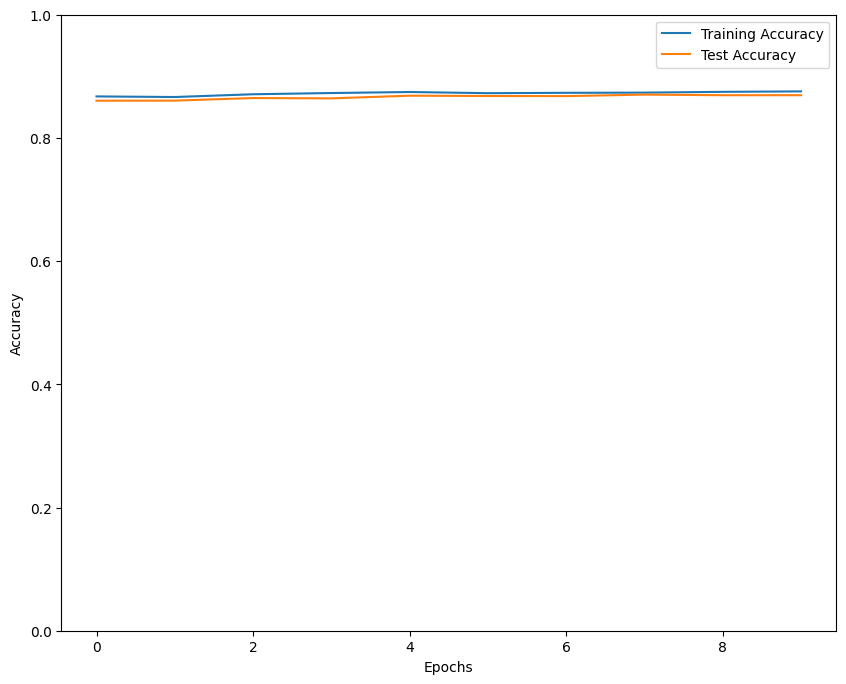

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

x_axis = np.arange(len(train_accuracies))
plt.plot(x_axis, train_accuracies, label="Training Accuracy")
plt.plot(x_axis, test_accuracies, label="Test Accuracy")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

## 학습 결과 분석
- 모델이 AG News 데이터셋에 대해 잘 학습되었으며, 약 87%의 정확도로 뉴스 기사를 분류할 수 있습니다.
- 과적합 문제가 크지 않아 실제 사용에 적합해 보입니다.
- 이 결과는 전반적으로, GPT 모델을 기반으로 한 뉴스 분류기가 효과적으로 작동하고 있음을 알 수 있습니다.